# AquaNet Temp & RH

In [1]:
import os
from matplotlib import pyplot as plt

from loguru import logger

logger.enable("nviro_fetch")

## Setup

In [3]:
from devices import check_and_load_devices
from env import env_global
from readings import (
    export_readings,
    import_readings,
    calculate_time_difference,
)

start_date = env_global("start_date")
end_date = env_global("end_date")
path_data = env_global("path_data")
path_readings = f"{path_data}/readings"
devices = check_and_load_devices()

## 1) Import

In [4]:
device_name = "AquaNet Temp & RH"
device = [device for device in devices if device["device_name"] == device_name][0]
df = import_readings(
    device_name=device["device_name"].replace(" ", "_").lower()
)

2025-06-17 12:30:01.461 | INFO     | readings:import_readings:71 - Importing readings from folder: /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/raw
2025-06-17 12:30:01.462 | INFO     | files:find_file:84 - Found file: aquanet_temp_&_rh_2025-06-11.csv for device: aquanet_temp_&_rh
2025-06-17 12:30:01.462 | INFO     | readings:import_readings:75 - Importing readings from file: aquanet_temp_&_rh_2025-06-11.csv
2025-06-17 12:30:01.467 | INFO     | readings:import_readings:85 - Readings imported successfully from /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/raw/aquanet_temp_&_rh_2025-06-11.csv


## 2) Common Interval


In [5]:
df["time_diff"] = calculate_time_difference(df["dt"])
df = df[df["time_diff"] >= 5]  # Filter out readings with time difference < 5 minutes

In [6]:
s_diff = df["time_diff"].value_counts().sort_values(ascending=False)
s_diff.head()

time_diff
10      2341
9         86
11        84
390        2
1210       1
Name: count, dtype: int64

In [7]:
interval_common = s_diff.index[0]
print(f"Most common time interval: {interval_common} minutes")

Most common time interval: 10 minutes


#### 2.2.1) Plot

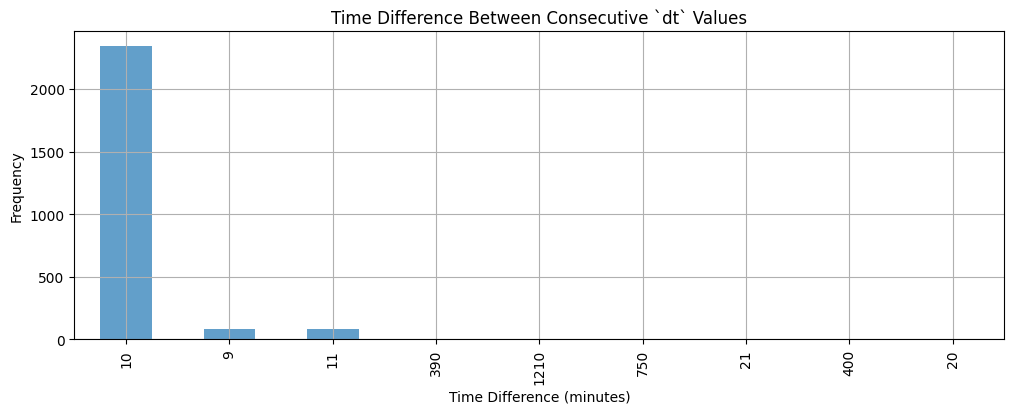

In [8]:
plt.figure(figsize=(12, 4))
s_diff.plot(kind="bar", alpha=0.7)
plt.title("Time Difference Between Consecutive `dt` Values")
plt.xlabel("Time Difference (minutes)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

ANS: 10 min

## 3) Round to common interval

In [9]:
df["dt_10"] = df.apply(
    lambda row: row["dt"].floor(f"{str(interval_common)} min"), axis=1
)

df["dt_diff"] = df.apply(
    lambda row: (row["dt"] - row["dt_10"]).total_seconds() / 60, axis=1
)

## 4) Check for any issues

In [10]:
s_diff = df["dt_diff"].value_counts().sort_values(ascending=False)
s_diff.head()

dt_diff
6.0    996
0.0    984
7.0    536
5.0      2
Name: count, dtype: int64

## 5) Set new date as default

In [11]:
df_final = df.copy(deep=True)
df_final.reset_index(inplace=True, drop=True)
df_final["datetime"] = df_final["dt_10"]
df_final.drop(columns=["dt" ,"time_diff", "dt_10", "dt_diff"], inplace=True)

## 6) Export

In [12]:
path_cleaned = os.path.join(path_readings, "cleaned")
end_date = df_final["datetime"].max().strftime("%Y-%m-%d %H:%M:%S")
export_readings(path_cleaned, df_final, device, end_date)